## Task: Job posting ingestion pipeline


### CoNVO

**Context:** Bloc is a career services management platform that builds smart career and data management tools for job-seekers and the organizations serving them. In particular, Bloc seeks to provide and facilitate access to tools for effectively presenting job-seekers' credentials and matching employers' job postings, and thereby improve outcomes.

**Need:** Job-seekers need help finding job postings that are aligned with their skills, goals, salary, and location (among other constraints), since that helps to reduce time spent filtering out bad matches and improve the likelihood of a successful outcome. Typical "fuzzy search" by job title, maybe with structured filters layered on top, performs decently well, but does take time. Unfortunately, an outside consumer of job postings like Bloc generally has more restricted options in terms of a jobs search.

**Vision:** Automated extraction of key information from job postings, and perhaps classification of postings into relevant categories, pulled from external data sources, in order to better match job postings with job-seekers.

**Outcome:** A standalone, proof-of-concept process for extracting key job posting information (and categorizing it into relevant classes), and returning it as structured data, complete with unit tests and documentation on expected usage, limitations, and potential improvements.


### Data Summary

A collection of ~4800 job postings for tech+data roles in several major U.S. cities have been fetched from the following external APIs:

- [GitHub Jobs API](https://jobs.github.com/api)
- [Indeed.com API](https://opensource.indeedeng.io/api-documentation/)
- [TheMuse.com API](https://www.themuse.com/developers/api/v2)

The APIs all return JSON-formatted data, but with a variety of fields and level of detail. All jobs include structured data for the job title, location, company, and URL, as well as a field containing either all or a short snippet of the job description as text data. These descriptions generally contain information on required / desired applicant qualifications, expected responsibilities and tasks, company missions and benefits, and more -- but snippets don't consistently contain the most important details.


### Proposed Methodology

The first and simplest task is to transform the structured data from each of the data sources into a consistent representation; in practice, this will entail renaming fields and parsing values (e.g. dates) into a standardized form. The second task is to extract as much relevant information from the free text job descriptions as possible -- key skills, technological expertise, education requirements, etc. -- in a form that allows for matching against job-seekers' skills, expertise, education. A combination of regular expressions, fuzzy string matching, and dictionary/gazetteer lookups, and other basic text processing will hopefully be enough to reliably extract info. The final, possibly optional task is to train text categorizers to predict classes of interest based on the descriptions' text: company culture? flexibility of work-life balance? Given the small size of the dataset, a simple bag-of-words-based approach may be more likely to succeed than, say, a deep learning model.


### Definitions of Success

- **Baseline:** A function that accepts a job posting from any of the three listed data sources and returns standardized, structured data for key job metadata (title, location, company, and posting URL), plus any available information on skills/expertise/education required or desired for the role. The quality of the extracted values may be messy or not fully structured, but shouldn't contain values from other fields. This function should have basic unit tests and documentation.
- **Target:** A function that accepts a job posting from any of the three listed data sources and returns standardized, structured data for key job metadata and available information on required/desired job qualifications (see Baseline), plus any available information on expected responsibilities and company mission/benefits. The quality of the extracted values should be mostly structured -- not large blobs of text, just the most informative bits -- and shouldn't contain values from other fields. This function should have unit tests covering a variety of expected scenarios and good documentation.
- **Stretch:** A function as described in Target, plus trained text categorization models for predicting one or more classes of interest. Text preprocessing and model structure must be documented, as well as validation results for model performance.


### Risks

It's possible that the information included in / extracted from job postings is too complex or varied for sufficiently accurate rules-based parsing, in which case a more sophisticated (ML- or DL-based) approach would be necessary, albeit impractical owing to time and data constraints. It's also possible that a rules-based approach is feasible, but too difficult / large a task for a single day's work.

Similarly, job categories that Bloc would find most useful may not be feasible given the size and limitations of the available training dataset. The challenge here is finding categorizations that are still useful but not too abstract/complex for a machine to learn with sufficient accuracy in a single day's work.

## Source Code

In [11]:
%load_ext watermark

### Dataset Generation

**Note:** Don't run this section! This is just to help you understand the data's provenance. Instead, download the already-generated datasets from OneDrive. (There's a link on the Bloc Project Home document in Dropbox.)

In [12]:
import io
import itertools
import json
import os
import random

import requests

In [13]:
%watermark -v -iv

requests 2.21.0
json     2.0.9
CPython 3.7.3
IPython 7.2.0


In [14]:
data_dir = "/home/colleen/projects/python_msvdd_Bloc/data/postings"
role_queries = [
    "web developer",
    "front-end developer",
    "back-end developer",
    "full-stack developer",
    "python",
    "data scientist",
    "data engineer",
]
category_queries = ["Engineering", "Data Science"]
locations = [
    "New York, NY",
    "Chicago, IL",
    "San Francisco, CA",
    "San Jose, CA",
    "Los Angeles, CA",
    "Seattle, WA",
    "Austin, TX",
    "Washington, DC",
    "Baltimore, MD",
    "Boston, MA",
]

In [15]:
def dedupe_results(results, dupe_key):
    """
    Args:
        results ((List[dict]))
        dupe_key (str)
    
    Returns:
        List[dict]
    """
    unique_results = []
    seen_keys = set()
    for result in results:
        if result[dupe_key] in seen_keys:
            continue
        else:
            seen_keys.add(result[dupe_key])
            unique_results.append(result)
    return unique_results


def chunk_items(items, chunk_size):
    """
    Yield successive chunks of items.
    
    Args:
        items (list or tuple)
        chunk_size (int)
    
    Yields:
        list or tuple
    """
    for i in range(0, len(items), chunk_size):
        yield items[i : min(i + chunk_size, len(items))]
        
    
def save_jobs_to_disk(data, filepath):
    """
    Args:
        data (List[dict])
        filepath (str)
    """
    with io.open(filepath, mode="wt", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

#### GitHub Jobs API

In [16]:
def search_github_jobs(*, query, location=None, limit=None):
    """
    Args:
        query (str): A search term, such as "ruby" or "java".
        location (str): Like "New York, NY".
        limit (int)
        
    Returns:
        List[dict]
    """
    base_url = "https://jobs.github.com/positions.json"
    params = {"description": query}
    if location:
        params["location"] = location
    results = []
    i = 0
    while True:
        page_params = params.copy()
        page_params["page"] = i
        try:
            response = requests.get(base_url, params=page_params)
            response.raise_for_status()
        except requests.RequestException as e:
            print(e)
            break
        page_results = response.json()
        results.extend(page_results)
        i += 1
        if len(page_results) < 50:
            break
        elif limit is not None and len(results) > limit:
            break
    if limit is not None:
        return results[:limit]
    else:
        return results

In [17]:
all_search_results = []
for query, location in itertools.product(role_queries, locations):
    print("(query, location) =>", (query, location))
    try:
        results = search_github_jobs(query=query, location=location, limit=100)
        all_search_results.extend(results)
    except Exception:
        break

# deduplicate the list of search results
github_jobs = dedupe_results(all_search_results, "id")
print("# jobs fetched =", len(github_jobs))
github_jobs[:1]

(query, location) => ('web developer', 'New York, NY')
(query, location) => ('web developer', 'Chicago, IL')
(query, location) => ('web developer', 'San Francisco, CA')
(query, location) => ('web developer', 'San Jose, CA')
(query, location) => ('web developer', 'Los Angeles, CA')
(query, location) => ('web developer', 'Seattle, WA')
(query, location) => ('web developer', 'Austin, TX')
(query, location) => ('web developer', 'Washington, DC')
(query, location) => ('web developer', 'Baltimore, MD')
(query, location) => ('web developer', 'Boston, MA')
(query, location) => ('front-end developer', 'New York, NY')
(query, location) => ('front-end developer', 'Chicago, IL')
(query, location) => ('front-end developer', 'San Francisco, CA')
(query, location) => ('front-end developer', 'San Jose, CA')
(query, location) => ('front-end developer', 'Los Angeles, CA')
(query, location) => ('front-end developer', 'Seattle, WA')
(query, location) => ('front-end developer', 'Austin, TX')
(query, locati

[{'id': '3e378b91-7cc0-486e-b18d-518ab29569e3',
  'type': 'Full Time',
  'url': 'https://jobs.github.com/positions/3e378b91-7cc0-486e-b18d-518ab29569e3',
  'created_at': 'Wed Sep 11 18:59:59 UTC 2019',
  'company': 'Simon & Schuster ',
  'company_url': 'https://www.simonandschuster.com/',
  'location': 'New York, NY',
  'title': 'Lead Software Engineer',
  'description': '<p>Simon &amp; Schuster is seeking a Lead Software Engineer to join a rapidly growing team focused on impacting the world of publishing through research and innovation. Working with a team of data scientists, data engineers, designers, and domain experts, you will be involved in rapidly prototyping, developing, and deploying the platforms that put insights and information into the hands of decision-makers.</p>\n<p>From databases to serverless applications, you will be designing, deploying , and managing the systems that connect our real-world data to the books and authors that inform and entertain our world. As a Full

In [18]:
save_jobs_to_disk(github_jobs, os.path.join(data_dir, "github_jobs.json"))

#### Indeed.com API

In [19]:
def search_indeed_jobs(publisher_id, user_ip, *, query, location=None, limit=None):
    """
    Args:
        publisher_id (str)
        user_ip (str)
        query (str): A search term, such as "ruby" or "java".
        location (str): Like "New York, NY".
        limit (int)
    
    Returns:
        List[dict]
    """
    base_url = "http://api.indeed.com/ads/apisearch"
    results_per_page = 25
    params = {
        "publisher": publisher_id,
        "userip": user_ip,
        "useragent": "blocbot python/v1",
        "v": 2,
        "format": "json",
        "filter": 1,
        "limit": results_per_page,  # not the same as `limit` kwarg
    }
    params["q"] = query
    if location:
        params["l"] = location
    start = 0
    results = []
    while True:
        page_params = params.copy()
        page_params["start"] = start
        try:
            response = requests.get(base_url, params=page_params)
            response.raise_for_status()
        except requests.RequestException as e:
            print(e)
            break
        page_results = response.json().get("results", [])
        results.extend(page_results)
        start += results_per_page
        if len(page_results) < results_per_page:
            break
        elif limit is not None and len(results) > limit:
            break
    if limit is not None:
        results = results[:limit]
    
    detailed_results = []
    job_keys = [result["jobkey"] for result in results]
    base_url = "http://api.indeed.com/ads/apigetjobs"
    params = {
        "publisher": publisher_id,
        "userip": user_ip,
        "v": 2,
        "format": "json",
    }
    for job_keys_chunk in chunk_items(job_keys, 10):
        chunk_params = params.copy()
        chunk_params["jobkeys"] = ",".join(job_key for job_key in job_keys_chunk)
        try:
            response = requests.get(base_url, params=chunk_params)
            response.raise_for_status()
        except requests.RequestException as e:
            print(e)
            break
        chunk_results = response.json().get("results", [])
        detailed_results.extend(chunk_results)
    return detailed_results

In [7]:
with io.open("/Users/burtondewilde/.bloc/indeed", mode="rt") as f:
    publisher_id = f.read().strip()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/burtondewilde/.bloc/indeed'

In [14]:
user_ip = requests.get("https://api.ipify.org").text

In [10]:
all_search_results = []
for query, location in itertools.product(role_queries, locations):
    print("(query, location) =>", (query, location))
    try:
        results = search_indeed_jobs(publisher_id, user_ip, query=query, location=location, limit=100)
        all_search_results.extend(results)
    except Exception:
        break

# deduplicate the list of search results
indeed_jobs = dedupe_results(all_search_results, "jobkey")
print("# jobs fetched =", len(indeed_jobs))
indeed_jobs[:1]

NameError: name 'role_queries' is not defined

In [20]:
save_jobs_to_disk(indeed_jobs, os.path.join(data_dir, "indeed_jobs.json"))

NameError: name 'indeed_jobs' is not defined

#### The Muse API

In [21]:
def search_themuse_jobs(*, category, location=None, limit=None):
    """
    Args:
        category (str): Job category to search.
        location (str): Like "New York, NY".
        limit (int)
        
    Returns:
        List[dict]
    """
    if category not in _CATEGORIES:
        raise ValueError(
            "category={} is invalid; valid values are {}".format(category, _CATEGORIES))
    base_url = "https://www.themuse.com/api/public/jobs"
    params = {"category": category}
    if location:
        params["location"] = location
    results = []
    i = 0
    while True:
        page_params = params.copy()
        page_params["page"] = i
        try:
            response = requests.get(base_url, params=page_params)
            response.raise_for_status()
        except requests.RequestException as e:
            print(e)
            break
        data = response.json()
        page_results = data.get("results", [])
        results.extend(page_results)
        i += 1
        if len(page_results) < data["items_per_page"]:
            break
        elif limit is not None and len(results) > limit:
            break
    if limit is not None:
        return results[:limit]
    else:
        return results
    
    
_CATEGORIES = {
    "Account Management",
    "Business & Strategy",
    "Creative & Design",
    "Customer Service",
    "Data Science",
    "Editorial",
    "Education",
    "Engineering",
    "Finance",
    "Fundraising & Development",
    "Healthcare & Medicine",
    "HR & Recruiting",
    "Legal",
    "Marketing & PR",
    "Operations",
    "Project & Product Management",
    "Retail",
    "Sales",
    "Social Media & Community",
}

In [22]:
all_search_results = []    
for category, location in itertools.product(category_queries, locations):
    print("(category, location) =>", (category, location))
    try:
        results = search_themuse_jobs(category=category, location=location, limit=100)
        all_search_results.extend(results)
    except Exception:
        break

# deduplicate the list of search results
themuse_jobs = dedupe_results(all_search_results, "id")
print("# jobs fetched =", len(themuse_jobs))
themuse_jobs[:1]

(category, location) => ('Engineering', 'New York, NY')
(category, location) => ('Engineering', 'Chicago, IL')
(category, location) => ('Engineering', 'San Francisco, CA')
(category, location) => ('Engineering', 'San Jose, CA')
(category, location) => ('Engineering', 'Los Angeles, CA')
(category, location) => ('Engineering', 'Seattle, WA')
(category, location) => ('Engineering', 'Austin, TX')
(category, location) => ('Engineering', 'Washington, DC')
(category, location) => ('Engineering', 'Baltimore, MD')
(category, location) => ('Engineering', 'Boston, MA')
(category, location) => ('Data Science', 'New York, NY')
(category, location) => ('Data Science', 'Chicago, IL')
(category, location) => ('Data Science', 'San Francisco, CA')
(category, location) => ('Data Science', 'San Jose, CA')
(category, location) => ('Data Science', 'Los Angeles, CA')
(category, location) => ('Data Science', 'Seattle, WA')
(category, location) => ('Data Science', 'Austin, TX')
(category, location) => ('Data S

[{'contents': "<p><br><br>Collaborate with Technology Division teams as a pool of developers dedicated to delivering key priorities. Act as 'surge squad' responsible for accelerating a specific high impact Technology Division project.<br>You will be expected to conduct world-class research in areas of your specialization (within the domain of Artificial Intelligence - Natural Language Understanding, causal extraction, knowledge representation and reasoning). You will work with other researchers and developers within the R&amp;D group and with other teams in GS to develop breakthrough ideas in this space, create proof of concept realizations, develop intellectual property and participate in external research communities (giving talks, publishing papers, attending conferences, organizing meetings)<br><br><strong> RESPONSIBILITIES AND QUALIFICATIONS </strong> <br><br><strong>HOW YOU WILL FULFILL YOUR POTENTIAL</strong><br>• Conduct research in the areas of Artificial Intelligence<br>• Man

In [23]:
save_jobs_to_disk(themuse_jobs, os.path.join(data_dir, "themuse_jobs.json"))

#### combined dataset

(assuming no duplicates across sources)

In [24]:
print("total # of jobs fetched = ", len(github_jobs + indeed_jobs + themuse_jobs))

NameError: name 'indeed_jobs' is not defined

### Getting Started

In [42]:
import os
import re

import en_core_web_md
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import spacy
import textacy

In [43]:
%matplotlib inline

In [44]:
%watermark -v -iv

requests       2.21.0
en_core_web_md 2.1.0
missingno      0.4.2
spacy          2.2.1
json           2.0.9
pandas         0.23.4
matplotlib     3.0.2
re             2.2.1
textacy        0.8.0
CPython 3.7.3
IPython 7.2.0


#### load / inspect data

In [45]:
def load_dataset(filepath, **kwargs):
    """
    Args:
        filepath (str)
        kwargs: Additional params passed as-is
            into :func:`pd.read_json()`, useful for setting
            dataset-specific dtypes, etc.
    
    Returns:
        :class:`pd.DataFrame`
    """
    # almost too easy ;)
    return pd.read_json(path_or_buf=filepath, **kwargs)


def inspect_dataset(dataset):
    """
    Args:
        dataset (:class:`pd.DataFrame`)
    """
    print("shape:", dataset.shape)
    print("columns:", ", ".join(dataset.columns))
    return dataset.describe(include="all")

In [46]:
data_dir = "/home/colleen/projects/python_msvdd_Bloc/data/postings"

In [47]:
df_github = load_dataset(os.path.join(data_dir, "github_jobs.json"))
inspect_dataset(df_github)

shape: (66, 11)
columns: company, company_logo, company_url, created_at, description, how_to_apply, id, location, title, type, url


,company,company_logo,company_url,created_at,description,how_to_apply,id,location,title,type,url
count,66,48,58,66,66,66,66,66,66,66,66
unique,57,48,52,66,66,63,66,47,59,1,66
top,SailPoint,https://jobs.github.com/rails/active_storage/b...,https://www.sailpoint.com/,2018-11-09 16:54:38,<p>Join our team and develop the next generati...,"<p>Email us at <a href=""mailto:careers@playvs....",4cd29974-e48b-11e8-8478-fb9810f86b79,"New York, NY",Full Stack Developer,Full Time,https://jobs.github.com/positions/3ad2842a-bfb...
freq,3,1,3,1,1,2,1,5,3,66,1
first,NaN,NaN,NaN,2018-10-22 15:56:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2019-10-04 23:56:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# what's the average length (in chars) of job descriptions?
df_github["description"].str.len().describe()

count       66.000000
mean      3560.909091
std       1729.590105
min          1.000000
25%       2622.500000
50%       3160.000000
75%       4234.500000
max      10467.000000
Name: description, dtype: float64

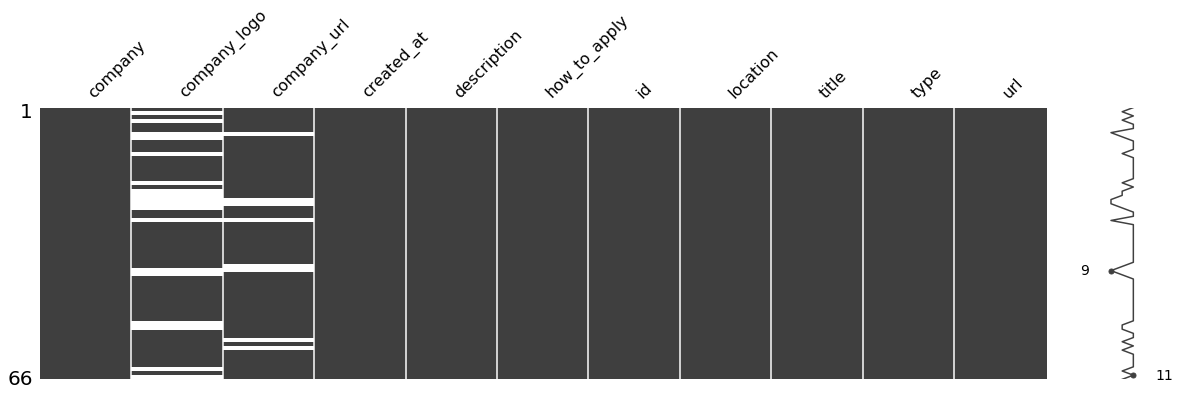

In [49]:
_ = msno.matrix(df_github, figsize=(20, 5))

In [41]:
df_indeed = load_dataset(os.path.join(data_dir, "indeed_jobs.json"))
inspect_dataset(df_indeed)


shape: (0, 0)
columns: 


ValueError: Cannot describe a DataFrame without columns

In [45]:
# what's the average length (in chars) of job descriptions?
df_indeed["snippet"].str.len().describe()

KeyError: 'snippet'

ValueError: zero-size array to reduction operation minimum which has no identity

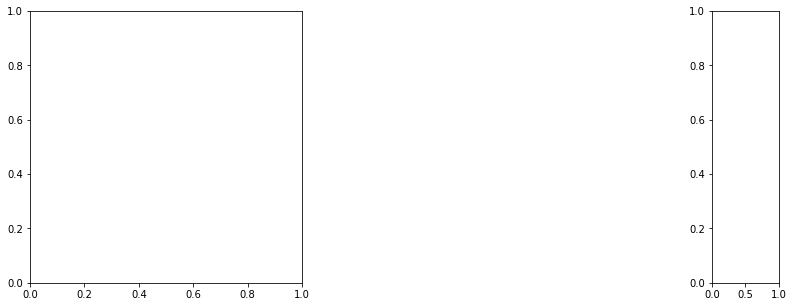

In [43]:
_ = msno.matrix(df_indeed, figsize=(20, 5))

In [50]:
df_themuse = load_dataset(os.path.join(data_dir, "themuse_jobs.json"))
inspect_dataset(df_themuse)

shape: (568, 13)
columns: categories, company, contents, id, levels, locations, model_type, name, publication_date, refs, short_name, tags, type


,categories,company,contents,id,levels,locations,model_type,name,publication_date,refs,short_name,tags,type
count,568,568,568,5.680000e+02,568,568,568,568,568,568,568,568,568
unique,9,80,537,NaN,8,34,1,472,568,568,546,3,2
top,[{'name': 'Engineering'}],"{'id': 792, 'short_name': 'northropgrumman', '...",<p>Join a team that has been partnering with o...,NaN,[],"[{'name': 'New York, NY'}]",jobs,Summer/Intern Student,2019-07-30T01:48:29.590301Z,{'landing_page': 'https://www.themuse.com/jobs...,senior-software-engineer,[],external
freq,525,82,16,NaN,231,90,568,16,1,1,5,439,561
mean,NaN,NaN,NaN,1.901373e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,3.970222e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,3.074000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,1.774684e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2.063980e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,2.175266e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# what's the average length (in chars) of job descriptions?
df_themuse["contents"].str.len().describe()

count     568.000000
mean     3960.153169
std      1301.442606
min       275.000000
25%      3046.000000
50%      3915.500000
75%      4834.250000
max      9961.000000
Name: contents, dtype: float64

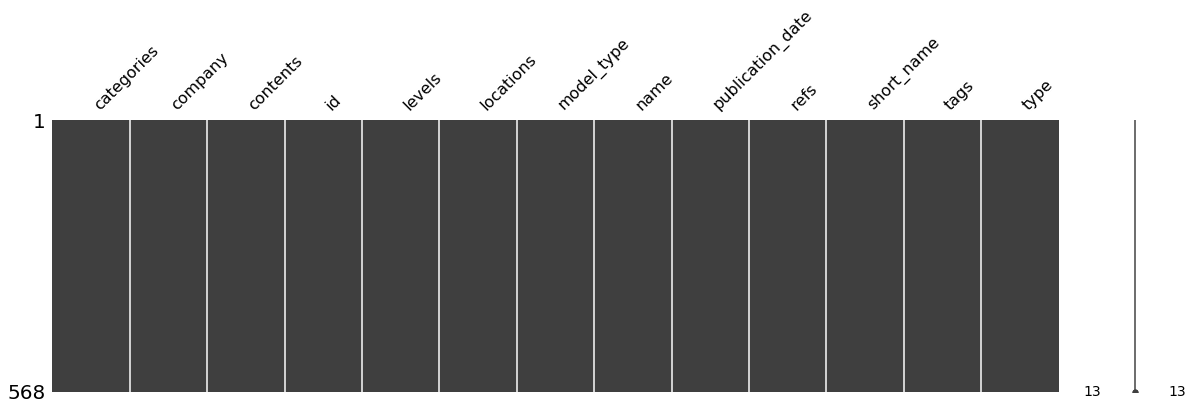

In [52]:
_ = msno.matrix(df_themuse, figsize=(20, 5))

#### munge data

In [53]:
from html.parser import HTMLParser


class _HTMLParser(HTMLParser):
    
    def __init__(self):
        super().__init__()
        self._texts = []
    
    def handle_data(self, data):
        self._texts.append(data)
        
    def get_text(self):
        return "".join(self._texts)


def extract_text_from_html(html):
    """
    Basic, stdlib-only function for extracting text data from HML.
    
    Args:
        html (str)
        
    Returns:
        str
    """
    parser = _HTMLParser()
    parser.feed(html)
    parser.close()
    return parser.get_text().strip()

In [54]:
df_themuse.loc[:, "text"] = df_themuse["contents"].map(extract_text_from_html)
df_themuse["text"]

0      Language diverse monorepo seeks experienced wr...
1      In a Site Reliability Engineering role at Bees...
2      Etsy is looking for an experienced Engineering...
3      The company:\n\nWe're on a mission to build th...
4      About This Position \n\nAs a senior backend en...
5      We have enormous and engaging technical challe...
6      ENGINEERING     What We Do  At Goldman Sachs, ...
7      DescriptionThere are approximately 80,000 quer...
8      INVESTMENT BANKINGOur division works on some o...
9      How do you keep a data-intensive, real-time se...
10     Fixed Income, Currency, and Commodities (FICC)...
11     What We Do  At Goldman Sachs, our Engineers do...
12     Want to help people get the financial protecti...
13     mParticle is growing our product engineering t...
14     At Datadog, we're on a mission to bring sanity...
15     Have you ever wondered what happens inside the...
16     What We DoAt Goldman Sachs, our Engineers don'...
17     Affirm is reinventing cr

#### text categorization training dataset?

Below, I'm looking for key words (in context) that might be used to build up a training dataset for text categorization.

In [55]:
_ = df_themuse.loc[df_themuse["text"].str.contains("diversity"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "diversity"))

p. We are an equal opportunity employer and value  diversity  at our company. We do not discriminate on the bas
k) We are an equal opportunity employer and value  diversity  at our company. We do not discriminate on the bas
their needs—whether remote or in office. We value  diversity  and inclusivity. We are an equal opportunity empl
People Come First" is a core value and that’s why  diversity  and inclusion are vital to our priorities as an e
People Come First" is a core value and that’s why  diversity  and inclusion are vital to our priorities as an e
their needs—whether remote or in office. We value  diversity  and inclusivity. We are an equal opportunity empl
their needs—whether remote or in office. We value  diversity  and inclusivity. We are an equal opportunity empl
or everyoneA company that embraces and celebrates  diversity Fantastic location near Bryant Park with easy walk
happy hours, ample snacks and drinks VTS embraces  diversity  and equal opportunity in a serious way. We

In [52]:
_ = df_themuse.loc[df_themuse["text"].str.contains("work[ /–-]life balance"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "work[ /–-]life balance"))

pany match • PTO, company paid holidays and great  work/life balance  • Fun and Flexible work environment that puts peo
pany match • PTO, company paid holidays and great  work/life balance  • Fun and Flexible work environment that puts peo
ompany match PTO, company paid holidays and great  work/life balance  Fun and Flexible work environment that puts peopl


In [53]:
_ = df_themuse.loc[df_themuse["text"].str.contains("benefits"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "benefits"))

in technical issues to non-technical team members  Benefits /Perks: In addition to offering world-class health
Perks: In addition to offering world-class health  benefits , 401(k) matching, parental leave, and highly comp
dependents 401(k) match, life insurance, commuter  benefits , corporate gym rates, paid time-off and parental 
lth, vision, and dental insurance 401(k) Commuter  benefits  Gym membership subsidy Trendy SoHo office Dog-fri
full-time employees are eligible for our terrific  benefits  program, which includes unlimited PTO, full healt
 paramount, in an environment that affords a rich  benefits  package and ample career growth. If this portrait
eh Huang, “America’s Dream Boss” for our generous  benefits . Every day is bring your dog to work day at Boxed
h, vision, and dental insurance -401(k) -Commuter  benefits  -Gym membership subsidy -Trendy SoHo office -Dog-
equityGreat medical, vision, dental, and commuter  benefits Generous family policiesTraining and career develo
.

In [54]:
_ = df_themuse.loc[df_themuse["text"].str.contains("Python"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "Python"))

 more server-side dynamic languages such as Ruby,  Python , or Javascript (NodeJS) Some experience in or exp
rs and customers Bonus points You are a master at  Python , Java, C++ or Go You have mastered Linux, from th
velop fully automated pipelines to build java and  python  projects, execute unit tests and end to end tests
ation code in at least one language such as java,  python , etc. Ability to create efficient scripts in pyth
thon, etc. Ability to create efficient scripts in  python  and bashExperience in taking application code and
 (Aurora), EFS, API Gateway Preferred Skills: Java Python GroovyGradleAgileKubernetesRuby Additional Informa
 a dynamically typed language -- we primarily use  Python , but members of our team have backgrounds in a wi
ting well designed code (our stack is JavaScript,  Python , MySQL, and PostgreSQL) Experience building and d
tributed systemsExperience with scripting such as  Python  or RubyExperience with software deployment and or
ferred), AWS, Azure